In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# FMCW Radar with Corner Reflector and CFAR Detection

## Introduction

This notebook demonstrates a complete **FMCW radar system** with a corner reflector target, including advanced detection techniques using **CFAR (Constant False Alarm Rate)** algorithms. This combination is essential for radar calibration, testing, and understanding detection thresholds in real-world scenarios.

### FMCW Radar Overview

**FMCW (Frequency-Modulated Continuous Wave) radar** transmits a continuous signal with linearly varying frequency. This enables simultaneous measurement of target range and velocity through beat frequency analysis.

**Key Advantages:**

1. **Simultaneous Range and Velocity**: Single waveform measures both parameters
2. **High Range Resolution**: ΔR = c/(2B), where B is bandwidth
3. **Continuous Operation**: No blind ranges during transmission
4. **Low Peak Power**: Energy spread over time, simpler hardware
5. **Multiple Target Capability**: Separate targets by beat frequencies

**Operating Principle:**

$$f_{beat} = \frac{2BR}{cT_c} + \frac{2vf_c}{c}$$

Where:
- $f_{beat}$ = Beat frequency (Hz)
- $B$ = Chirp bandwidth (Hz)
- $R$ = Target range (m)
- $T_c$ = Chirp duration (s)
- $v$ = Radial velocity (m/s)
- $f_c$ = Carrier frequency (Hz)
- $c$ = Speed of light (3×10⁸ m/s)

### Corner Reflector as Calibration Target

**Corner reflectors** (trihedral reflectors) are ideal for radar calibration and testing because they:

1. **High RCS**: Strong, predictable return (σ ∝ a⁴/λ²)
2. **Wide Beamwidth**: Forgiving alignment (40-60° typical)
3. **Polarization Preservation**: Maintains incident polarization
4. **Stable Performance**: Weather-independent, no moving parts
5. **Known Signature**: Theoretical RCS for validation

**Applications:**
- **Radar Calibration**: Verify system performance and gain
- **Test Targets**: Controlled scenarios for algorithm development
- **Ground Control Points**: SAR image georeferencing
- **Navigation Markers**: Marine and aviation aids

### CFAR Detection Theory

**CFAR (Constant False Alarm Rate)** detection maintains a constant probability of false alarm despite varying clutter levels.

**Why CFAR?**

Simple threshold detection fails when:
- Clutter intensity varies spatially
- Interference creates hot spots
- Receiver gain changes with range
- Multiple targets mask weaker ones

**CFAR Algorithms:**

1. **CA-CFAR (Cell Averaging)**:
   - Averages power in reference cells
   - Threshold = α × average
   - Simple, effective for uniform clutter

2. **OS-CFAR (Ordered Statistic)**:
   - Uses k-th ordered statistic
   - Robust to outliers and multiple targets
   - Better in dense target environments

**CFAR Parameters:**

- **Guard cells**: Protect against target spillover into reference
- **Training/trailing cells**: Estimate local noise/clutter level
- **P_fa**: Probability of false alarm (10⁻⁴ to 10⁻⁶ typical)
- **Detector**: "linear" (power) or "square" (amplitude)

### Two-Dimensional CFAR

**2D CFAR** operates on range-Doppler maps to handle:
- Range-dependent clutter
- Doppler-dependent interference
- Simultaneous range and velocity detection
- Improved rejection of false alarms

**Process:**
1. Compute range-Doppler map via 2D FFT
2. Apply 2D CFAR sliding window
3. Compare each cell to adaptive threshold
4. Extract detections exceeding threshold

### You'll Learn How To:

- Configure a 77 GHz FMCW radar for calibration scenarios
- Model a corner reflector target with known motion
- Simulate radar returns using ray tracing
- Apply combined range-Doppler FFT processing
- Implement 2D OS-CFAR for adaptive detection
- Visualize range-Doppler maps with detection thresholds
- Understand CFAR parameter selection and trade-offs
- Compare radar returns with CFAR threshold surface
- Extract target range and velocity from detections

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate:

**Scenario:**
- 77 GHz FMCW radar
- Corner reflector at 50m range
- Target approaching at -5 m/s
- 256 chirps for Doppler processing

**Processing Pipeline:**
1. Range-Doppler FFT with Chebyshev windows
2. OS-CFAR detection with 2D sliding window
3. 3D visualization of returns and threshold

The simulation demonstrates how CFAR adapts detection thresholds to maintain constant false alarm rate while detecting the high-RCS corner reflector.

## Radar System Configuration

Configure a 77 GHz FMCW radar suitable for calibration and testing.

### Import Required Modules

Import necessary RadarSimPy modules and NumPy for numerical operations.

In [2]:
# Import necessary modules for radar simulation
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter Configuration

Configure the FMCW transmitter with parameters optimized for calibration and detection.

#### Define FMCW Radar Transmitter

Configure the chirp waveform for range and Doppler measurement.

**Chirp Parameters:**

- **Frequency Range**: 76.95-77.05 GHz
  - Center: 77 GHz (automotive W-band)
  - Bandwidth: B = 100 MHz
  - Range resolution: ΔR = c/(2B) = 1.5 m

- **Chirp Duration**: 80 μs (explicit [0, 80μs])
  - Fast-time sampling period
  - Determines range sampling

- **Transmit Power**: 25 dBm (~316 mW)
  - Moderate power for test scenarios
  - Adequate for corner reflector detection

- **Pulse Repetition Period**: 100 μs
  - Time between chirps
  - PRF = 10 kHz
  - Unambiguous velocity: ±19.5 m/s

- **Number of Pulses**: 256
  - Chirps in CPI
  - Doppler resolution: Δv ≈ 0.076 m/s
  - Good balance between resolution and processing time

In [3]:
# Define transmitter antenna location
tx_channel = dict(
    location=(0, 0, 0),  # Position at origin
)

# Configure FMCW transmitter
tx = Transmitter(
    f=[77e9 - 50e6, 77e9 + 50e6],  # Frequency sweep: 76.95-77.05 GHz (100 MHz BW)
    t=[0, 80e-6],                   # Chirp duration: 0-80 μs (explicit time range)
    tx_power=25,                    # Transmit power: 25 dBm (316 mW)
    prp=100e-6,                     # Pulse repetition period: 100 μs
    pulses=256,                     # Number of chirps: 256
    channels=[tx_channel],          # Transmitter antenna configuration
)

### Receiver Configuration

Configure the receiver for baseband sampling and signal conditioning.

#### Define Radar Receiver

Set up receiver parameters for optimal detection performance.

**Receiver Parameters:**

- **Sampling Rate**: 2 MHz
  - Captures beat frequencies up to 1 MHz (Nyquist)
  - Maximum range: ~240 m

- **Noise Figure**: 8 dB
  - Typical receiver noise performance
  - Affects detection range

- **RF Gain**: 20 dB
  - Low-noise amplifier gain
  - Boosts weak signals

- **Load Resistor**: 500 Ω
  - Power-to-voltage conversion
  - Impedance matching

- **Baseband Gain**: 30 dB
  - IF amplifier gain
  - Total system gain: 50 dB

In [4]:
# Define receiver antenna location
rx_channel = dict(
    location=(0, 0, 0),  # Co-located with transmitter (monostatic)
)

# Configure radar receiver
rx = Receiver(
    fs=2e6,              # Sampling rate: 2 MHz
    noise_figure=8,      # Noise figure: 8 dB
    rf_gain=20,          # RF gain: 20 dB
    load_resistor=500,   # Load resistance: 500 Ω
    baseband_gain=30,    # Baseband gain: 30 dB
    channels=[rx_channel],  # Receiver antenna configuration
)

### Create Radar System

Combine transmitter and receiver to form the complete FMCW radar.

In [5]:
# Create complete radar system
radar = Radar(transmitter=tx, receiver=rx)

## Corner Reflector Target Model

Configure a moving corner reflector for radar detection and tracking.

### Target Configuration

**Corner Reflector Properties:**

- **Model**: Trihedral corner reflector STL mesh
- **Location**: 50m range along x-axis
- **Velocity**: -5 m/s (approaching radar)
- **RCS**: High, predictable return for detection

**Expected Doppler:**
- f_d = 2v·f_c/c = 2×(-5)×77×10⁹/(3×10⁸) ≈ -2.57 kHz
- Appears in negative Doppler bins (closing target)

In [6]:
# Configure corner reflector target
target_1 = {
    "model": "../models/cr.stl",  # Trihedral corner reflector 3D model
    "unit": "m",                   # Model units in meters
    "location": (50, 0, 0),       # Position: 50m along x-axis
    "speed": (-5, 0, 0),          # Velocity: 5 m/s approaching (closing)
}

# Create target list for simulation
targets = [target_1]

### Visualize Corner Reflector Model

Display the trihedral corner reflector geometry showing the three perpendicular surfaces.

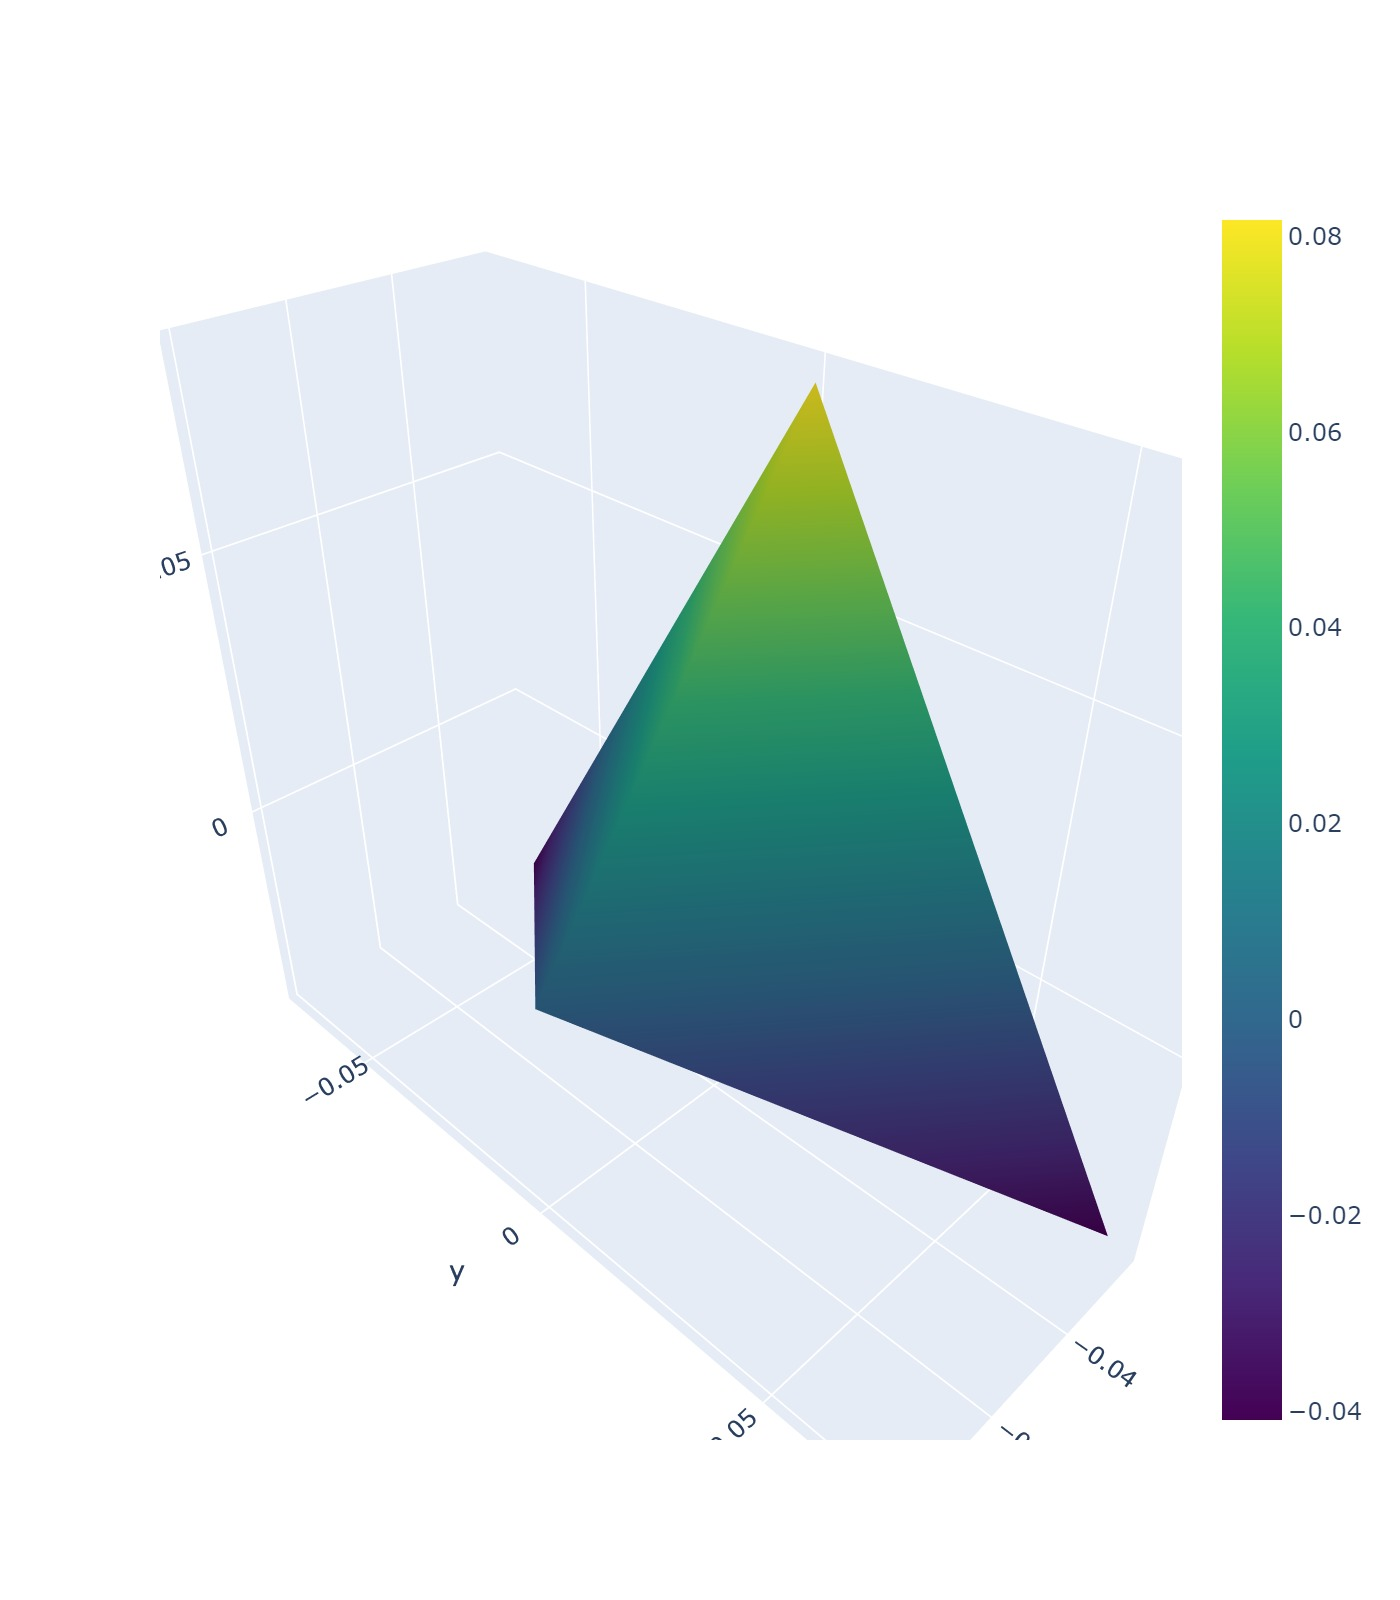

In [7]:
# Import libraries for 3D visualization
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

# Load corner reflector 3D mesh
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())    # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=v_matrix[:, 2],        # Z coordinates
        i=f_matrix[:, 0],        # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",      # Color scheme
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Simulate FMCW radar returns from the corner reflector using ray tracing.

### Simulation Parameters

**Ray Tracing Configuration:**

- **Density**: 0.2 rays per wavelength²
  - Higher than typical to capture corner reflector's complex triple-bounce
  - Ensures accurate RCS for calibration scenarios
  - Balances accuracy with computation time

**Output Data:**

The simulation returns complex I/Q baseband samples:
- **Dimensions**: [channels, pulses, samples]
- **Channels**: 1 (single Tx/Rx)
- **Pulses**: 256 chirps
- **Samples**: ~160 per chirp (2 MHz × 80 μs)

**Expected Results:**

Strong return at:
- **Range**: 50m → Beat frequency ≈ 417 kHz
- **Velocity**: -5 m/s → Doppler ≈ -2.57 kHz

In [8]:
# Import radar simulator and timing module
from radarsimpy.simulator import sim_radar
import time

# Start timing
tic = time.time()

# Simulate radar returns from corner reflector
# density=0.2: Higher ray density for accurate corner reflector RCS
data = sim_radar(radar, targets, density=0.2)

# Extract baseband I/Q signals and add system noise
baseband = data["baseband"] + data["noise"]  # Complex samples (I + jQ)

# End timing
toc = time.time()

# Display execution time
print("Exec time:", toc - tic, "s")

Exec time: 0.29456233978271484 s


## Radar Signal Processing

Apply two-dimensional FFT processing to generate range-Doppler map.

### Range-Doppler FFT Processing

**Combined Processing:**

The `range_doppler_fft` function performs both range and Doppler FFTs in one operation:

1. **Range FFT**: Across fast-time (ADC samples)
   - Converts beat frequencies to range bins
   - Window: Chebyshev with 60 dB sidelobe suppression

2. **Doppler FFT**: Across slow-time (chirps/pulses)
   - Extracts velocity from phase progression
   - Window: Chebyshev with 60 dB sidelobe suppression

**Output:**

Range-Doppler map with dimensions:
- [channels, Doppler_bins, range_bins]
- Shows target location in range-velocity space

In [9]:
# Import signal processing modules
from scipy import signal
import radarsimpy.processing as proc

# Create Chebyshev windows for sidelobe suppression (60 dB)
range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)

# Perform combined range-Doppler FFT
# Input: baseband [channels, pulses, samples]
# Output: range_doppler [channels, Doppler_bins, range_bins]
range_doppler = proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window)

### Visualize Range-Doppler Map

Generate 3D surface plot showing corner reflector detection in range-velocity space.

**Expected Features:**

1. **Strong Peak**: Corner reflector at ~50m, -5 m/s
2. **High SNR**: Clean detection above noise floor
3. **Narrow Peak**: Good resolution in both dimensions
4. **Minimal Sidelobes**: Chebyshev windowing suppresses artifacts

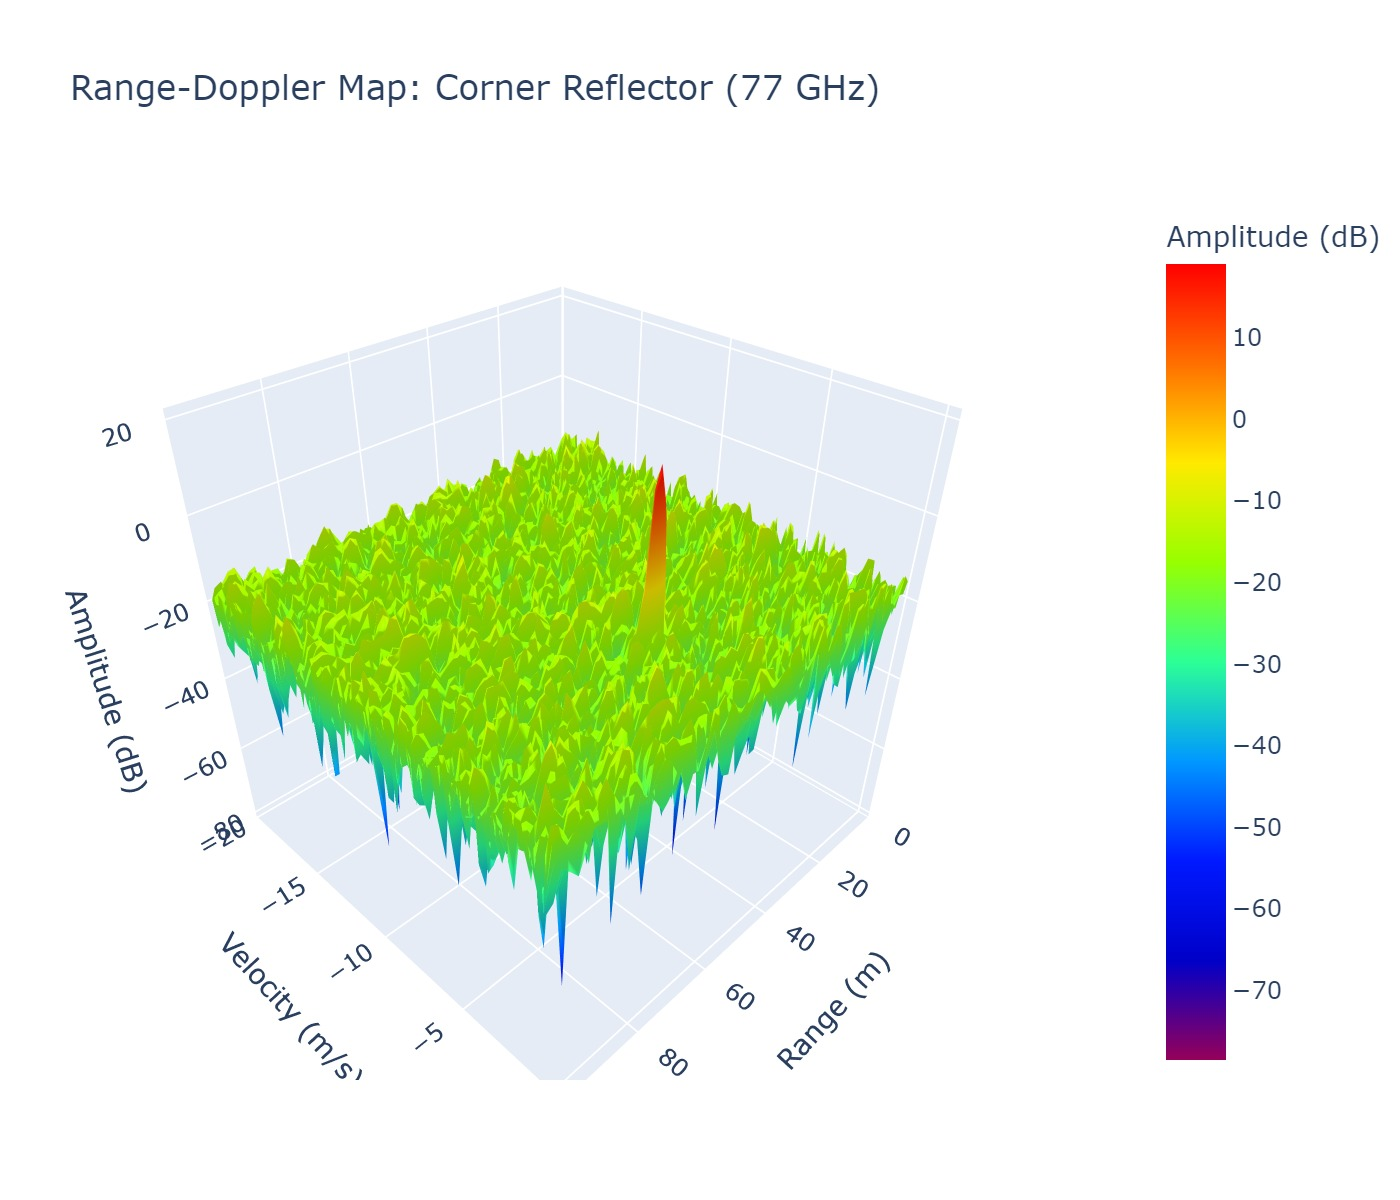

In [10]:
# Calculate maximum unambiguous range
max_range = (
    3e8  # Speed of light
    * radar.radar_prop["receiver"].bb_prop["fs"]  # Sampling rate
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]  # Chirp duration
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]  # Chirp bandwidth
    / 2  # Two-way propagation
)

# Calculate unambiguous velocity
unambiguous_speed = (
    3e8  # Speed of light
    / radar.radar_prop["transmitter"].waveform_prop["prp"][0]  # PRP
    / 77e9  # Carrier frequency
    / 2  # Two-way Doppler
)

# Create range axis (0 to max_range)
range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

# Create velocity axis (-v_max to 0)
doppler_axis = np.linspace(
    -unambiguous_speed,
    0,
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

# Create 3D surface plot
fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=range_axis,                                    # Range axis (m)
        y=doppler_axis,                                  # Velocity axis (m/s)
        z=20 * np.log10(np.abs(range_doppler[0, :, :])),  # Power in dB
        colorscale="Rainbow",                            # Color scheme
        colorbar=dict(title="Amplitude (dB)"),
    )
)

# Configure 3D plot layout
fig.update_layout(
    title="Range-Doppler Map: Corner Reflector (77 GHz)",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)", range=[0, 100]),  # Focus on target range
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### CFAR Detection

Apply **2D OS-CFAR (Ordered Statistic CFAR)** for adaptive threshold detection.

**CFAR Algorithm Selection:**

RadarSimPy provides two CFAR algorithms:
- **CA-CFAR** (`cfar_ca_2d`): Cell-Averaging, simple and fast
- **OS-CFAR** (`cfar_os_2d`): Ordered Statistic, robust to outliers

We use **OS-CFAR** because:
- More robust in presence of multiple targets
- Better performance with interfering targets
- k-th statistic provides outlier rejection

**CFAR Parameters:**

1. **Guard Cells**: 2
   - Cells immediately around test cell
   - Prevents target energy from contaminating reference
   - Too few → false alarms; too many → reduced sensitivity

2. **Trailing Cells**: 20
   - Reference cells for noise/clutter estimation
   - Forms sliding window around guard cells
   - More cells → better statistics, slower processing

3. **P_fa**: 10⁻⁴ (0.0001)
   - Probability of false alarm
   - 1 false alarm per 10,000 cells
   - Lower → fewer false alarms but may miss weak targets

4. **k**: 1500
   - Ordered statistic rank (for OS-CFAR)
   - Determines which sorted sample to use
   - Higher k → more conservative threshold

5. **Detector**: "linear"
   - Operates on power (not amplitude)
   - Alternative: "square" for amplitude detection

In [11]:
# Average range-Doppler map across channels (if multiple)
rdop_avg = np.mean(np.abs(range_doppler), axis=0)

# Apply 2D OS-CFAR detection
cfar = proc.cfar_os_2d(
    rdop_avg,           # Input: Range-Doppler magnitude map
    guard=2,            # Guard cells: 2 (protect against target spillover)
    trailing=20,        # Trailing cells: 20 (reference for threshold)
    pfa=1e-4,           # Probability of false alarm: 0.0001
    k=1500,             # Ordered statistic rank
    detector="linear"   # Detector type: linear (power detection)
)

# CFAR output is adaptive threshold surface matching input dimensions

### Visualize Range-Doppler Map with CFAR Threshold

Display both the radar returns and adaptive CFAR threshold surface for comparison.

**Visualization:**

- **Rainbow surface**: Radar returns (signal + noise)
- **Viridis surface**: CFAR adaptive threshold
- **Detection**: Occurs where signal exceeds threshold

**Interpretation:**

1. **Corner Reflector Peak**: High amplitude exceeds CFAR threshold
2. **Threshold Adaptation**: CFAR surface follows local noise level
3. **Guard Region**: Threshold rises near target to prevent spillover
4. **Detection Margin**: Difference between peak and threshold indicates SNR

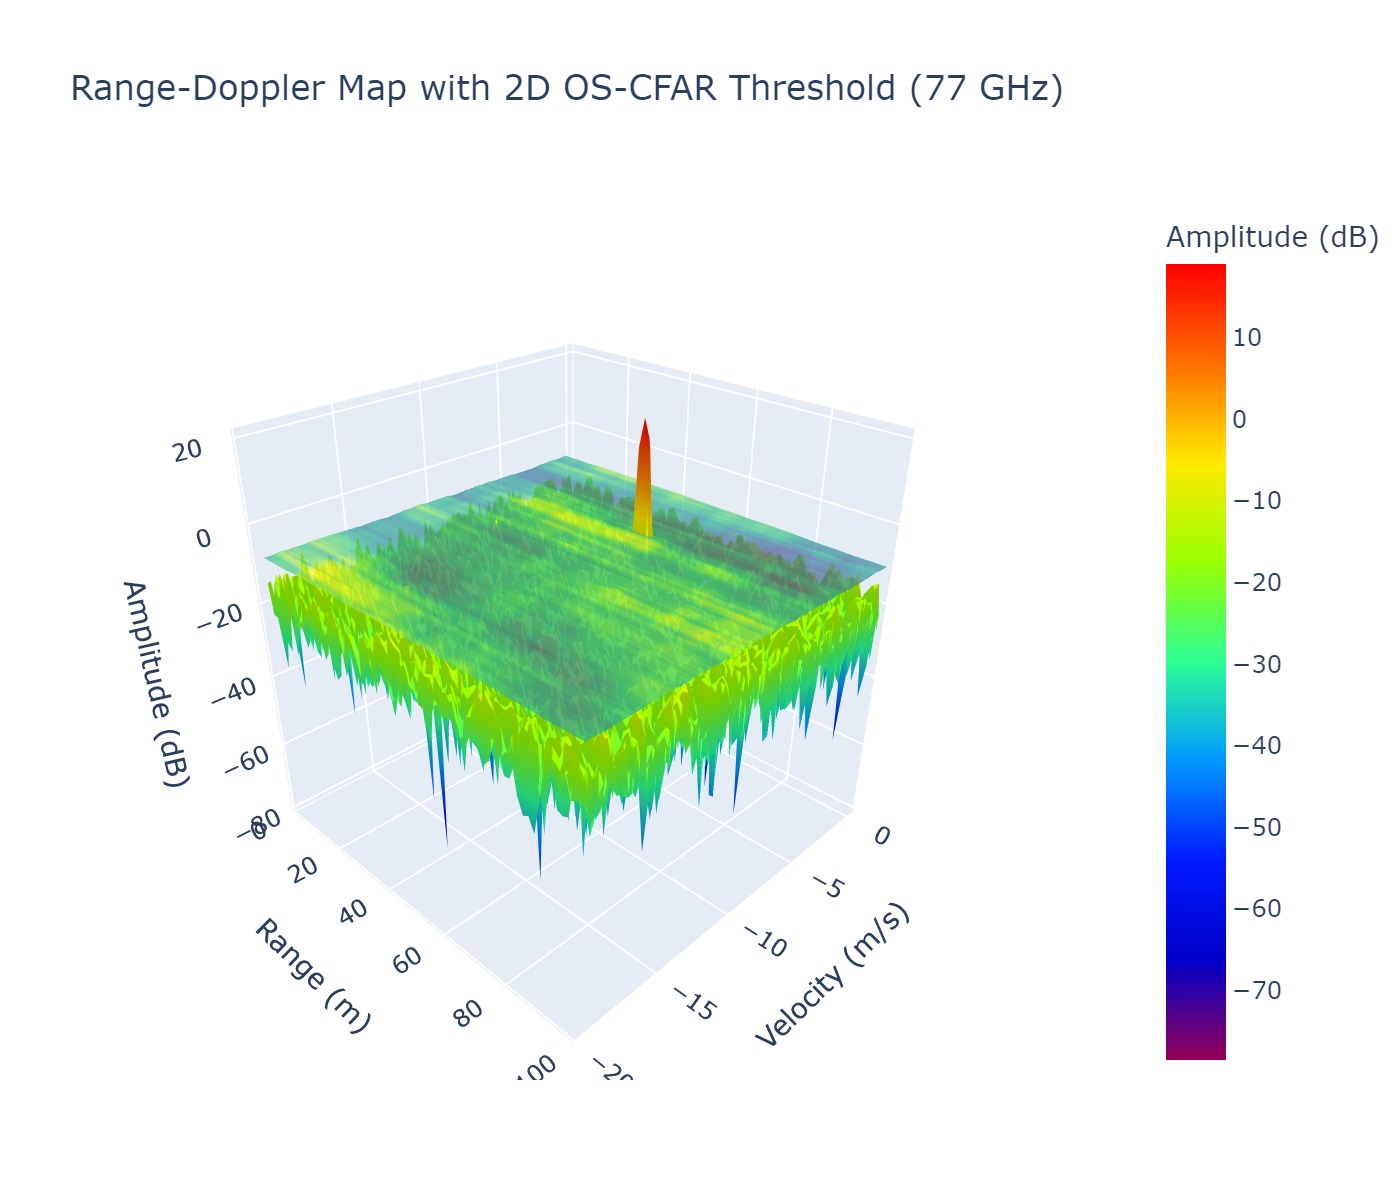

In [12]:
# Create 3D surface plot with radar returns and CFAR threshold
fig = go.Figure()

# Add radar return surface (signal + noise)
fig.add_trace(
    go.Surface(
        x=range_axis,                      # Range axis (m)
        y=doppler_axis,                    # Velocity axis (m/s)
        z=20 * np.log10(rdop_avg),        # Radar returns in dB
        colorscale="Rainbow",              # Rainbow colormap for signal
        name="Radar Returns",
        showscale=True,
        colorbar=dict(title="Amplitude (dB)", x=1.0),
    )
)

# Add CFAR threshold surface
fig.add_trace(
    go.Surface(
        x=range_axis,                      # Range axis (m)
        y=doppler_axis,                    # Velocity axis (m/s)
        z=20 * np.log10(cfar),            # CFAR threshold in dB
        colorscale="Viridis",              # Viridis colormap for threshold
        name="CFAR Threshold",
        showscale=False,                   # Don't show separate scale
        opacity=0.7,                       # Semi-transparent to see both surfaces
    )
)

# Configure 3D plot layout
fig.update_layout(
    title="Range-Doppler Map with 2D OS-CFAR Threshold (77 GHz)",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)", range=[0, 100]),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
        camera=dict(eye=dict(x=1.5, y=-1.5, z=1.2)),  # Better viewing angle
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h", y=-0.1),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to implement FMCW radar with CFAR detection using RadarSimPy:

### Key Takeaways

**1. FMCW Radar with Calibration Target**
- Configured 77 GHz radar for corner reflector detection
- Used 100 MHz bandwidth for 1.5m range resolution
- Implemented 256 chirps for 0.076 m/s velocity resolution
- Demonstrated radar calibration scenario

**2. Corner Reflector Characteristics**
- High RCS provides strong, reliable return
- Predictable signature ideal for testing and calibration
- Triple-bounce retroreflection preserves polarization
- Wide beamwidth simplifies alignment

**3. Range-Doppler Processing**
- Applied combined range-Doppler FFT for efficient processing
- Used Chebyshev windows for 60 dB sidelobe suppression
- Generated 2D map showing target in range-velocity space
- Observed clean detection at 50m range, -5 m/s velocity

**4. CFAR Detection Theory**
- Understood need for adaptive thresholding
- Learned difference between CA-CFAR and OS-CFAR
- Recognized OS-CFAR robustness to outliers and multiple targets
- Appreciated constant false alarm rate maintenance

**5. 2D CFAR Implementation**
- Applied OS-CFAR to range-Doppler map
- Configured guard cells (2) to prevent target spillover
- Set trailing cells (20) for noise estimation
- Selected P_fa = 10⁻⁴ for false alarm control

**6. CFAR Parameter Selection**
- Guard cells balance protection vs. sensitivity
- More trailing cells improve statistics but increase computation
- Lower P_fa reduces false alarms but may miss weak targets
- k parameter (OS-CFAR) controls threshold conservativeness

**7. Detection Visualization**
- Compared radar returns with adaptive threshold surface
- Observed threshold adaptation to local conditions
- Identified detection where signal exceeds threshold
- Quantified detection margin (SNR)

### Experiment Further

Try modifying the parameters to explore different scenarios:

1. **CFAR Parameter Optimization**:
   - Vary guard cells: 1, 3, 5
   - Change trailing cells: 10, 30, 50
   - Test different P_fa: 10⁻³, 10⁻⁵, 10⁻⁶
   - Adjust k for OS-CFAR sensitivity

2. **CA-CFAR vs. OS-CFAR Comparison**:
   - Replace with `cfar_ca_2d` function
   - Compare threshold surfaces
   - Analyze detection performance
   - Test with multiple targets

3. **Target Scenarios**:
   - Multiple corner reflectors at different ranges
   - Add weak target near strong one (masking scenario)
   - Stationary vs. moving targets
   - Various velocities: 0, ±10, ±15 m/s

4. **Range and Velocity Variations**:
   - Near range: 10m, 20m
   - Far range: 100m, 150m
   - High closing velocity: -20 m/s
   - Opening velocity: +10 m/s

5. **Chirp Configuration**:
   - Increase bandwidth: 200 MHz, 500 MHz
   - More chirps: 512, 1024 (finer Doppler resolution)
   - Shorter PRP (wider velocity ambiguity)
   - Longer observation time

6. **Window Function Studies**:
   - Compare Hamming, Hanning, Blackman
   - Test different sidelobe levels: 40 dB, 80 dB
   - Analyze main lobe width impact
   - Understand resolution vs. sidelobe trade-offs

7. **SNR Analysis**:
   - Vary transmit power: 15 dBm, 30 dBm, 35 dBm
   - Change receiver noise figure: 4 dB, 12 dB
   - Add attenuation to simulate range effects
   - Plot detection probability vs. SNR

8. **Clutter Scenarios**:
   - Add ground plane for multipath
   - Include multiple clutter returns
   - Test CFAR in high clutter environment
   - Compare performance with/without CFAR

9. **Detection Post-Processing**:
   - Implement peak detection on thresholded map
   - Extract range and velocity estimates
   - Apply centroiding for sub-bin accuracy
   - Track detections across multiple frames

10. **Advanced CFAR Techniques**:
    - Implement GO-CFAR (Greatest Of)
    - Test SO-CFAR (Smallest Of)
    - Try hybrid CFAR algorithms
    - Adaptive parameter selection

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Processing Module: https://radarsimx.github.io/radarsimpy/process.html
- CFAR Detection: Adaptive thresholding algorithms and theory
- OS-CFAR: Ordered statistic and robust detection
- Range-Doppler Processing: Two-dimensional FFT techniques
- Corner Reflector Theory: RCS and calibration applications
- Radar Calibration: System verification and performance testing
- Detection Theory: Probability of detection and false alarm trade-offs